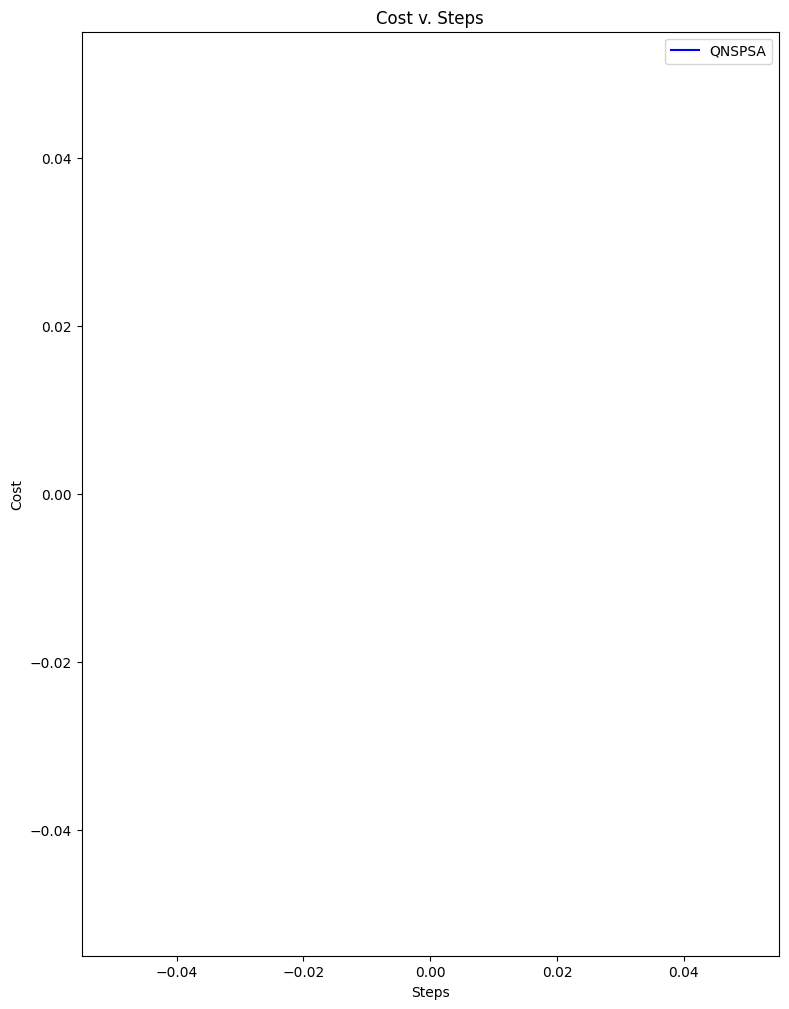

In [11]:
import torch
from torchvision.datasets import MNIST
import numpy as np
import qiskit 
from qiskit import transpile, compiler, QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ, Aer
from qiskit.opflow import X, Y, Z, I, StateFn
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap, TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import VQC
from qiskit.algorithms.optimizers import SPSA, QNSPSA,ADAM, adam_amsgrad, COBYLA
from qiskit.opflow import PauliExpectation
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.utils import algorithm_globals
from sklearn.preprocessing import OneHotEncoder
from qiskit.providers.fake_provider import FakeNairobiV2
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from qiskit.providers.ibmq import least_busy
if not IBMQ.active_account():
    provider=IBMQ.load_account()

n=7
#backend=provider.get_backend('qasm_simulator')
backend=Aer.get_backend('qasm_simulator')
algorithm_globals.random_seed = 3142
N=2
train_data, train_label, test_data, test_label = ad_hoc_data( 
    training_size=20,
    test_size=5,
    n=N,
    gap=0.3,
    one_hot=False
    )
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

np.random.seed(3142)
ad_hoc_in_circ=ZZFeatureMap(
    feature_dimension=N,
    reps=2
)
var_form=EfficientSU2(
    num_qubits=N,
    su2_gates=['ry', 'rz'],
    reps=2
)
initial_point = np.random.random(var_form.num_parameters)
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(train_label.reshape(-1, 1)
                                       ).toarray()
test_labels = encoder.fit_transform(test_label.reshape(-1, 1)
                                      ).toarray()
instance=QuantumInstance(backend, shots=200)
steps=100
def plot():

    plt.figure(figsize=(12, 9))
    for feature, label in zip(train_data, train_labels):
        plt.scatter(feature[0], feature[1], marker='o', s=100,
                    color='C1' if label[0] == 0 else 'C0')
    for feature, label, pred in zip(test_data, test_labels):
        plt.scatter(feature[0], feature[1], marker='s', s=100, color='C1' if pred[0] == 0 else 'C0')
        if not np.array_equal(label,pred):
            plt.scatter(feature[0], feature[1], marker='o', s=500,
                        linewidths=2.5, facecolor='none', edgecolor='C3')

    legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='+1'),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='-1'),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict +1',
           ),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict -1',
           ),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrong')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
            loc='upper left')

    plt.title('Training & Test Data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

steps=100
plt.figure(figsize=(9,12))
log=OptimizerLog()
instance=QuantumInstance(backend, shots=200)
vqc=VQC(
    feature_map=ad_hoc_in_circ,
    ansatz=var_form,
    optimizer=SPSA(maxiter=steps, callback=log.update),
    loss='cross_entropy',
    initial_point=initial_point,
    quantum_instance=backend,
)

vqc.fit(
    train_data, 
    train_labels,
)
#plt.plot(log.evaluations, log.costs, color='red', label='SPSA')

logQNSPSA=OptimizerLog()
instance=QuantumInstance(backend, shots=200)
fidelity=QNSPSA.get_fidelity(var_form, instance, PauliExpectation())
vqc=VQC(
    feature_map=ad_hoc_in_circ,
    ansatz=var_form,
    optimizer=QNSPSA(maxiter=steps, callback=log.update, fidelity=fidelity),
    loss='cross_entropy',
    initial_point=initial_point,
    quantum_instance=backend,
)

vqc.fit(
    train_data, 
    train_labels,
)
plt.plot(logQNSPSA.evaluations, logQNSPSA.costs, color='blue', label='QNSPSA')

plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title('Cost v. Steps')
plt.legend(loc='upper right')
plt.show()

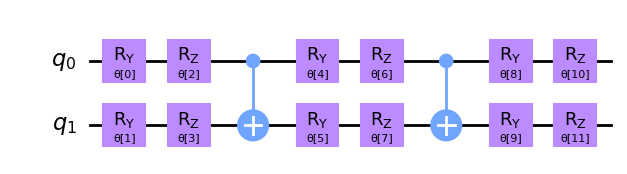

In [12]:
ad_hoc_in_circ=ZZFeatureMap(
    feature_dimension=N,
    reps=2
)
var_form.decompose().draw(output='mpl')


Text(0, 0.5, 'x_1')

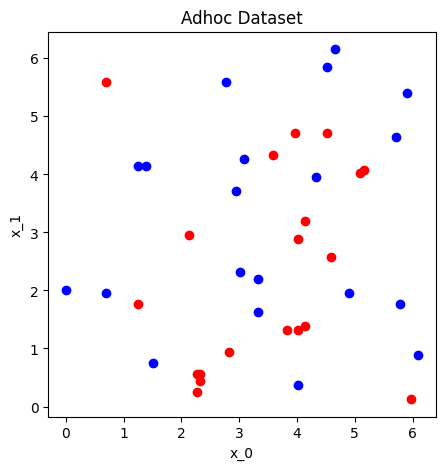

In [34]:
N=2
train_data, train_label, test_data, test_label = ad_hoc_data( 
    training_size=20,
    test_size=5,
    n=N, 
    gap=0.3,
    one_hot=False)

plt.figure(figsize=(5,5))
colors=[]
for i in range(len(train_label)): 
    plt.scatter(train_data[i][0], train_data[i][1], color='red' if train_label[i] == 0 else 'blue')
plt.title('Adhoc Dataset')
plt.xlabel('x_0')
plt.ylabel('x_1')


In [33]:
import pandas as pd
pd.DataFrame(train_data)

,0,1
0,2.638938,3.581416
1,3.958407,4.586725
2,3.581416,0.816814
3,4.084070,1.507964
4,4.335398,1.445133
5,3.644247,5.654867
6,0.502655,0.439823
7,2.261947,2.136283
8,2.261947,3.267256
9,5.717699,2.827433
